In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import traceback
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

from matplotlib.lines import Line2D
import matplotlib.patches as patches

In [2]:
%matplotlib notebook

In [3]:
def check_old_naming(animalid, session, fov, experiment='blobs', traceid='traces001',
                decode_type='single_cells', sub_dir='dff-nstds_stimulus', C_str='tuneC',
                rootdir='/n/coxfs01/2p-data'):
    
    res_files = glob.glob(os.path.join(rootdir, animalid, session, fov, 
                            'combined_%s_static' % experiment, 'traces', '%s*' % traceid, 
                            'decoding', decode_type, sub_dir, '*%s*.pkl' % C_str))
    for r in res_files:
        curr_dir, fname = os.path.split(r)
        if fname.startswith('single_cells_'):
            new_name = fname.split('single_cells_')[-1]
            os.rename(r, os.path.join(curr_dir, new_name))
    return


In [4]:
def plot_true_and_shuffled_distns(meandf, metric='heldout_test_score', return_scores=True, ax=None):
    '''
    Takes 
    '''
    
    tru_df = meandf[meandf['condition']=='data']
    shu_df = meandf[meandf['condition']=='shuffled']

    mean_score = tru_df[metric].mean()
    shuffled_score = shu_df[metric].mean()
    score_percentile = np.mean(mean_score < shu_df[metric])
    #print('%.2f, %.2f' % (mean_score, shuffled_score))

    # PLOT
    if ax is None:
        fig, ax = pl.subplots()
    sns.distplot(tru_df[metric], ax=ax, color='m')
    sns.distplot(shu_df[metric], ax=ax, color='k')
    ax.axvline(x=mean_score, linestyle=':', color='m')
    ax.axvline(x=shuffled_score, linestyle=':', color='k')
    
    if return_scores:
        return ax, mean_score, score_percentile
    else:
        return ax
    
    

In [5]:
def stripplot_by_area(metric, data_df, ax=None, area_colors=None, size=5,
                     visual_areas=['V1', 'Lm', 'Li', 'Ll'], scale=2, bar=True, annotate=True, xytext=(0, -10)):
    if ax is None:
        fig, ax = pl.subplots()
        
    if area_colors is None:
        cols = sns.color_palette('colorblind', n_colors=len(visual_areas))
        area_colors = dict((v, c) for v, c in zip(visual_areas, cols))    
    
    if bar or annotate:
        sns.barplot(x='visual_area',  y=metric, data=data_df, ax=ax,
                           order=visual_areas,
                           zorder=0, edgecolor='none', facecolor='none', color='none')
        data_df.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=xytext)
        
    sns.stripplot(x='visual_area',  y=metric, data=data_df, ax=ax,
               order=visual_areas, hue='visual_area',
               zorder=1, size=2, palette=area_colors)

    sns.pointplot(x='visual_area',  y=metric, data=data_df, ax=ax, join=False,
               order=visual_areas, markers='_', color='k', # palette=area_colors,
               scale=1, zorder=1000)
    
    return ax


In [6]:
def get_single_cell_files(animalid, session, fovnum, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None, 
                               test_type=None,
                               verbose=False, rootdir='/n/coxfs01/2p-data'):
    # Get results ID (data identifier)
    result_id = dc.create_results_id(prefix='single_cells',
                            visual_area=visual_area, C_value=C_value, 
                            response_type=response_type, responsive_test=responsive_test, 
                            trial_epoch=trial_epoch, test_type=test_type)
    
    curr_datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
    traceid_dir = dc.get_traceid_dir_from_datakey(curr_datakey, traceid=traceid)
    
    src_dir, save_prefix = dc.single_cell_dst_dir(traceid_dir, result_id)
        
    if src_dir is None:
        print("%s - Missing: (%s_%s_%s) %s" % (visual_area, session, animalid, fov, result_id))
        return None, None, None
        
    varea, c_str = save_prefix.split('_') #'tuneC' if C_value is None else 'C%.2f' % C_value
      
    # FInd all results files
    result_fpaths=[]
    missing_fpaths=[]
    if roi_list is None and visual_area is None:
        result_fpaths = glob.glob(os.path.join(src_dir, '*%s*.pkl' % c_str))
    else:
        if roi_list is None:
            result_fpaths =  glob.glob(os.path.join(src_dir, '%s*.pkl' % (save_prefix)))
        else:
            tmp_fns = [os.path.join(src_dir, '%s__%03d.pkl' % (save_prefix, int(rid+1))) \
                                         for rid in roi_list]
            for c in tmp_fns:
                if not os.path.exists(c):
                    missing_fpaths.append(c)
                else:
                    result_fpaths.append(c)
                    
    if verbose:
        print("(%s, %s) Found %i. Missing %i." % (session, animalid, len(result_fpaths), len(missing_fpaths)))
    
    return result_fpaths, missing_fpaths, result_id

            
def load_cell_results_from_fov(animalid, session, fovnum, experiment, traceid='traces001',
                               C_value=None, response_type='dff', responsive_test='nstds',
                               trial_epoch='stimulus', visual_area=None, roi_list=None,
                               test_type=None,
                               rootdir='/n/coxfs01/2p-data', verbose=False):
    '''
    From running batch, slurm/decode_by_ncells.py (Set analysis_type='single_cells'),
    load all the cells' results.
    '''
    roidf=None
    missing_rois=None
    result_id=None
    
    result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, 
                                roi_list=roi_list, verbose=verbose, test_type=test_type)
    
    if result_fns is None:
        return None, None, None
    
    if roi_list is not None:
        missing_rois = [int(os.path.splitext(os.path.split(f)[-1])[0].split('_')[-1])-1 for f in missing_fns]
        
    rlist=[]
    for c in result_fns:
        with open(c, 'rb') as f:
            res = pkl.load(f)
        res['iteration'] = res.index.tolist()
        res = res.reset_index(drop=True).sort_values(by='iteration')
        rlist.append(res)
    if len(rlist)>0:
        roidf = pd.concat(rlist, axis=0).reset_index(drop=True)
    
    return roidf, missing_rois, result_id


#### Test single-cell results loading

In [7]:
animalid = 'JC084'
session='20190522'
fovnum = 1

datakey='%s_%s_fov%i' % (session, animalid, fovnum)
visual_area='V1'

g = CELLS[(CELLS.visual_area==visual_area) & (CELLS.datakey==datakey)]
result_fns, missing_fns, result_id = get_single_cell_files(animalid, session, fovnum, experiment, traceid=traceid,
                               C_value=C_value, response_type=response_type, responsive_test=responsive_test,
                               trial_epoch=trial_epoch, visual_area=visual_area, 
                                roi_list=g['cell'].unique(), verbose=False, test_type=test_type)
print(len(result_fns))
print("missing: %i" % len(missing_fns))

NameError: name 'CELLS' is not defined

In [39]:
len(result_fns)

52

In [41]:
len(missing_fns)

55

# Dataset info

In [7]:
analysis_type='single_cells'
n_iterations=100

overlap_thr=None #0.5
n_processes=1
responsive_test='ROC'
experiment='blobs'
C_value=None

has_rfs = overlap_thr is not None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, 
         '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

# Set responsivitiy params
traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = 10.0 if responsive_test=='nstds' else 0.05 #float(opts.responsive_thr) #10
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

# Create data ID for labeling figures with data-types
stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
filter_str = 'filter_%s_%s' % (stim_filterby, g_str)
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, filter_str, response_str])
print(data_id)

# Choose what type classifier to make
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr is None else float(opts.overlap_thr) 

# Set classifier training params
C_value = opts.C_value
do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))
print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")


traces001|filter_None_blobsonly|dff_ROC-thr-0.05
Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None
............................................
Responsive test: ROC (thr=0.05)
............................................


In [8]:
train_str = 'by_singlecells_iter-%i' % (n_iterations)

# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)

dpi = putils.set_plot_params()

# Output dir

In [9]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

dst_dir = os.path.join(aggregate_dir, 'decoding', 'single_cells')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells


# Get metadata for experiment type

In [10]:
# #### Get metadata for experiment type
# sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)

# # sdata_exp = sdata[sdata['experiment']==experiment]
# #sdata_exp['visual_area'].unique()

# edata, expmeta = aggr.experiment_datakeys(experiment='blobs', has_rfs=has_rfs, 
#                             has_gratings=has_gratings, stim_filterby=None,
#                                 experiment_only=False)
# print(edata['visual_area'].unique())

In [11]:
#### Load neural responses
responsive_test='ROC' #'roc'
responsive_thr=10.0 if responsive_test=='nstds' else 0.05
trial_epoch= 'plushalf' #'stimulus'
response_type='dff'

print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

#### Check for equal trial counts
sdata, all_cells, MEANS, SDF = aggr.get_source_data(experiment, equalize_now=True, 
                                       response_type=response_type,
                                       responsive_test=responsive_test, 
                                       responsive_thr=responsive_thr, 
                                       trial_epoch=trial_epoch, check_configs=True, 
                                       zscore_now=True, return_configs=True, images_only=False) 
visual_areas = ['V1', 'Lm', 'Li'] #, 'Ll']
all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
sdf_master = aggr.get_master_sdf(images_only=True)

all_cells.groupby(['visual_area']).count()


............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])


,cell,fov,animalid,session,datakey,fovnum,global_ix
visual_area,,,,,,,
Li,652,652,652,652,652,652,652
Lm,1131,1131,1131,1131,1131,1131,1131
V1,1251,1251,1251,1251,1251,1251,1251


In [12]:
##### Get global cells
remove_too_few=False
min_ncells=5

overlap_thr=None
has_retino=False
threshold_dff=False
match_distns = False

stack_neuraldf = analysis_type=='by_ncells'

has_rfs = (has_retino is False) and (overlap_thr is not None)
print('retino:', has_retino, 'rfs:', has_rfs)
match_str = 'match-Li-distn' if match_distns else ''

results_prefix = analysis_type #set_results_prefix(analysis_type=analysis_type)
if threshold_dff:
    overlap_str='threshdff'
else:
    if has_retino:
        overlap_str = 'retino'
    else:
        overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

NDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                                threshold_snr=False, remove_too_few=remove_too_few) 
                                
print("------------------------------------")
print("Final cell counts:")
print(CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())


('retino:', False, 'rfs:', False)
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1131, u'Li': 652}
------------------------------------
------------------------------------
Final cell counts:
             datakey  cell
visual_area               
Li               652   652
Lm              1131  1131
V1              1251  1251


# Decode

In [13]:
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106


In [14]:
# Load single_cells pass

In [15]:
percentiles = dc.load_single_cells_pass(responsive_test=responsive_test)
percentiles.groupby(['visual_area']).count()['cell']

visual_area
Li     562
Lm    1105
V1    1251
Name: cell, dtype: int64

In [ ]:
p_thr=0.1
# Filter
#excl=['20190314_JC070_fov1', '20190327_JC073_fov1'] if analysis_type=='by_ncells' else []
excl=[]
pass_single = score_percentiles[(percentiles['percentile']<=p_thr)
                               & ~(percentiles['datakey'].isin(excl))].copy()
pass_single['mean_score'] = pass_single['mean_score'].astype(float)
pass_single.groupby(['visual_area']).count()['cell']

In [14]:
trial_epoch

'plushalf'

# Aggregate all single cell results

In [14]:
#### Setup output dirs
test_type='size_subset'
results_id = dc.create_results_id(prefix=results_prefix,
                        visual_area=None, C_value=C_value, trial_epoch=trial_epoch, 
                        response_type=response_type, responsive_test=responsive_test,
                        overlap_thr=overlap_thr, has_retino=has_retino, threshold_dff=threshold_dff,
                        test_type=test_type)

print(results_id)

single_cells_None__dff-ROC_noRF__plushalf__tuneC__size_subset


In [15]:
missing_files = dict((k, dict()) for k in visual_areas)
r_list=[]
for (visual_area, animalid, session, fovnum, datakey), g \
        in CELLS.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
        
    cell_lut={}
    roidf=None; missing=None; tmpid=None;
    try: 
        roidf, missing, tmpid = load_cell_results_from_fov(animalid, session, 
                             fovnum, experiment, C_value=C_value, trial_epoch=trial_epoch,
                             response_type=response_type, responsive_test=responsive_test,
                             visual_area=visual_area, roi_list=g['cell'].values, verbose=False,test_type=test_type)
    except Exception as e:
        print("ERROR: %s, %s" %(visual_area, datakey))
        traceback.print_exc()
        
        
    if missing is not None and len(missing)>0:
        missing_files[visual_area][datakey] = np.array(missing)
        
    if roidf is None:
        print("[%s] %s - No cells." % (visual_area, datakey))
        continue
    
    n_expected = len(g['cell'].unique()) 
    n_found = len(roidf['cell'].unique())
    if n_expected != n_found:
        print('Unequal (%s, %s) - Missing %i' % (visual_area, datakey, n_expected-n_found))

    if 'global_ix' in g.columns:
        cell_lut = dict((k,v) for k, v in zip(g['cell'].values, g['global_ix'].values))
        roidf['global_ix'] = [cell_lut[c] for c in roidf['cell'].values]
    else:
        print("(%s, %s) - no global" % (visual_area, datakey))

    metainfo = {'datakey': datakey, 'visual_area': visual_area}
    roidf = putils.add_meta_to_df(roidf, metainfo)
    r_list.append(roidf)

singledf = pd.concat(r_list, axis=0)

Unequal (Li, 20190319_JC067_fov1) - Missing 2
Unequal (Li, 20190314_JC070_fov1) - Missing 1
Unequal (Li, 20190327_JC073_fov1) - Missing 2
Unequal (Li, 20190422_JC076_fov1) - Missing 5
Unequal (Li, 20190602_JC091_fov1) - Missing 55
Unequal (Li, 20190614_JC091_fov1) - Missing 35
Unequal (Li, 20190609_JC099_fov1) - Missing 24
Unequal (Li, 20190612_JC099_fov1) - Missing 7
Unequal (Li, 20191018_JC113_fov1) - Missing 43
Unequal (Li, 20191105_JC117_fov1) - Missing 64
Unequal (Lm, 20190430_JC078_fov1) - Missing 25
Unequal (Lm, 20190504_JC078_fov1) - Missing 24
Unequal (Lm, 20190509_JC078_fov1) - Missing 35
Unequal (Lm, 20190513_JC078_fov1) - Missing 50
Unequal (Lm, 20190506_JC080_fov1) - Missing 135
Unequal (Lm, 20190603_JC080_fov1) - Missing 5
Unequal (Lm, 20190508_JC083_fov1) - Missing 98
Unequal (Lm, 20190512_JC083_fov1) - Missing 36
Unequal (Lm, 20190627_JC091_fov1) - Missing 23
Unequal (Lm, 20190618_JC097_fov1) - Missing 33
[Lm] 20191105_JC117_fov1 - No cells.
Unequal (V1, 20190501_JC076_

In [16]:
# singledf.groupby(['condition', 'train_transform', 'test_transform']).mean()

['x(50)', 'x(40)', 'x(30)', 'x(20)', 'x(10)']


<IPython.core.display.Javascript object>


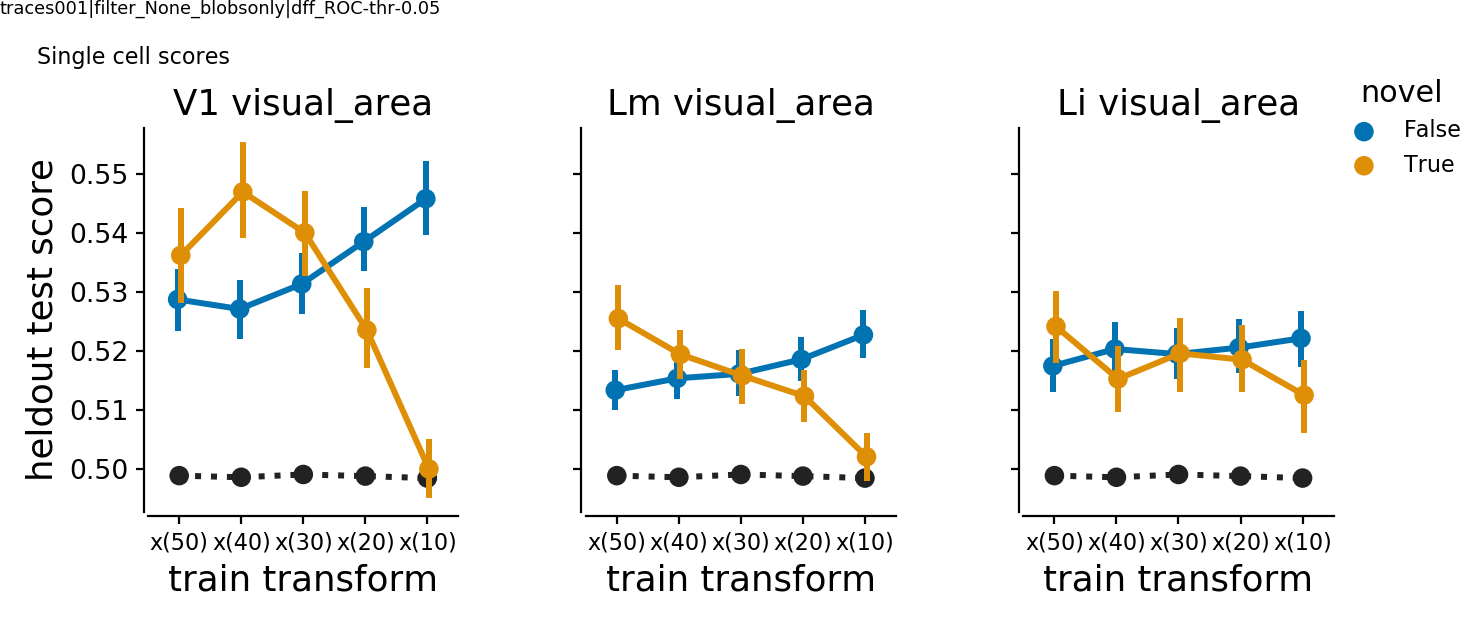

Text(0.025,0.9,u'Single cell scores')

In [17]:
metric_label='heldout test score'
mdf = singledf.groupby(['visual_area', 'datakey', 'cell', 'condition', 'train_transform', 'test_transform']).mean().reset_index()

all_sizes = sorted(mdf[mdf.novel]['test_transform'].astype(int))
train_labels = ['x(%i)' % int([s for s in all_sizes if s not in [int(i) for i in tlabel.split('_')]][0]) \
                 for tlabel in mdf['train_transform'].unique()]
print(train_labels)


g = sns.catplot(x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='data'], 
            hue='novel', palette='colorblind', dodge=True, kind='point', 
            col='visual_area', col_order=visual_areas, height=4, aspect=0.7, legend_out=True)

g.map(sns.pointplot, x='train_transform', y='heldout_test_score', data=mdf[mdf.condition=='shuffled'],
      hue='novel', linestyles=':', legend_out=True)

(g.set_axis_labels("train transform", metric_label)\
     .set_titles("{col_name} {col_var}")\
     .despine(offset=2)\
#      .set(ylim=(0.4, 0.6))\
     .set_xticklabels(train_labels, fontsize=10))

pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.9)
g._legend.set(bbox_to_anchor=(1., 0.8))

putils.label_figure(g.fig, data_id)
g.fig.text(0.025, 0.9, 'Single cell scores')


In [18]:
# pp.pprint(dict((k, v.keys()) for k, v in missing_files.items()))
for v, vdict in missing_files.items():
    for d, dlist in vdict.items():
        print('[%s] %s (missing %i)' % (v, d, len(dlist)))

[V1] 20190511_JC083_fov1 (missing 61)
[V1] 20190613_JC097_fov1 (missing 108)
[V1] 20191006_JC110_fov1 (missing 49)
[V1] 20190622_JC085_fov1 (missing 178)
[V1] 20190501_JC076_fov1 (missing 18)
[V1] 20190522_JC084_fov1 (missing 92)
[V1] 20190616_JC097_fov1 (missing 146)
[V1] 20190507_JC083_fov1 (missing 4)
[V1] 20190510_JC083_fov1 (missing 13)
[V1] 20190617_JC097_fov1 (missing 123)
[Lm] 20190509_JC078_fov1 (missing 35)
[Lm] 20190430_JC078_fov1 (missing 25)
[Lm] 20190512_JC083_fov1 (missing 36)
[Lm] 20190603_JC080_fov1 (missing 5)
[Lm] 20190506_JC080_fov1 (missing 135)
[Lm] 20190513_JC078_fov1 (missing 50)
[Lm] 20190508_JC083_fov1 (missing 98)
[Lm] 20190618_JC097_fov1 (missing 33)
[Lm] 20190627_JC091_fov1 (missing 23)
[Lm] 20190504_JC078_fov1 (missing 24)
[Lm] 20191105_JC117_fov1 (missing 4)
[Li] 20190327_JC073_fov1 (missing 2)
[Li] 20191018_JC113_fov1 (missing 43)
[Li] 20190319_JC067_fov1 (missing 2)
[Li] 20190609_JC099_fov1 (missing 24)
[Li] 20190602_JC091_fov1 (missing 55)
[Li] 2019061

In [19]:
# Average bootstrap iterations together
group_cols = ['visual_area', 'datakey', 'cell', 'condition']
if test_type is not None:
    group_cols.extend([ 'train_transform', 'test_transform'])
    
itermean = singledf.groupby(group_cols).mean().reset_index()

# Get counts
counts_by_fov = itermean[['visual_area', 'datakey', 'cell', 'global_ix']].drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
counts_by_fov.groupby(['visual_area']).sum()

,cell,global_ix
visual_area,,
Li,414,414
Lm,663,663
V1,459,459


In [20]:
# stat_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats'
# for r in 
# glob.glob(os.path.join(stat_dir, 'aggr_blobs_*_ROC*'))

# Filter cells that don't pass 

In [20]:
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells


In [21]:

if test_type is not None:
    traindf = singledf[singledf.train_transform==singledf.test_transform].copy()
else:
    traindf = singledf.copy()
    
traindf[(traindf.visual_area=='V1') & (traindf.datakey=='20190522_JC084') & (traindf.cell==4)].shape

(0, 23)

In [26]:
dk = traindf[traindf.visual_area=='V1']['datakey'].unique()[0]
rid = traindf[(traindf.visual_area=='V1') & (traindf.datakey==dk) ]['cell'].unique()[0]
d_ = traindf[(traindf.visual_area=='V1') & (traindf.datakey==dk) & (traindf.cell==rid)].copy()
d_.groupby(['condition']).count()

,C,fit_time,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,...,test_score,test_transform,train_score,train_transform,iteration,n_cells,cell,datakey,global_ix,visual_area
condition,,,,,,,,,,,,,,,,,,,,,
data,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
shuffled,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500


In [27]:
# Calculate percentiles
percentiles = decutils.get_percentile_shuffled(traindf)


In [28]:
p_thr=0.1

metric='heldout_test_score'
filter_pass = True

pass_perc = percentiles[percentiles.percentile<=p_thr].copy() #[['visual_area', 'datakey']].copy()
pass_keys = [(k, v, c) for k, v, c in pass_perc[['visual_area', 'datakey', 'cell']].values]

pass_str=''
if filter_pass:
    pass_str = '_aboveshuffled-%.2f' % p_thr
    passdf = pd.concat([g for (v, k, c), g in itermean.groupby(['visual_area', 'datakey', 'cell']) \
                    if (v, k, c) in pass_keys]).reset_index(drop=True)
    print(passdf.groupby(['condition', 'visual_area'])[metric].mean())
    print(passdf.shape, itermean.shape)
else:
    passdf = itermean.copy()

print(pass_str)
ncells_pass = passdf[['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()
print(ncells_pass)


condition  visual_area
data       Li             0.565029
           Lm             0.554308
           V1             0.565211
shuffled   Li             0.496867
           Lm             0.497530
           V1             0.498349
Name: heldout_test_score, dtype: float64
((7995, 19), (23040, 19))
_aboveshuffled-0.10
V1    220
Lm    206
Li    107
Name: visual_area, dtype: int64


In [29]:
pass_str

'_aboveshuffled-0.10'

## Save percentiles

In [70]:
if test_type is None:
    tmp_out = os.path.join(dst_dir, 'single_cells_percentiles_%s.pkl' % responsive_test)# % overlap_str)
    with open(tmp_out, 'wb') as f:
        pkl.dump(percentiles, f, protocol=pkl.HIGHEST_PROTOCOL)

    print(tmp_out)

## filter

In [31]:
pass_datakeys = [(v, k, c) for v, k, c in passdf[['visual_area', 'datakey', 'cell']]\
                     .drop_duplicates().values]

all_datakeys = [(v, k, c) for v, k, c in itermean[['visual_area', 'datakey', 'cell']]\
                    .drop_duplicates().values]

print("%i of %i cells pass shuffle test (p=%.2f)" % (len(pass_datakeys), len(all_datakeys), p_thr))

dropped_ = [k for k in all_datakeys if k not in pass_datakeys]


533 of 1536 cells pass shuffle test (p=0.10)


In [32]:
pass_perc[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

,datakey,cell
visual_area,,
Li,107,107
Lm,206,206
V1,220,220


<IPython.core.display.Javascript object>


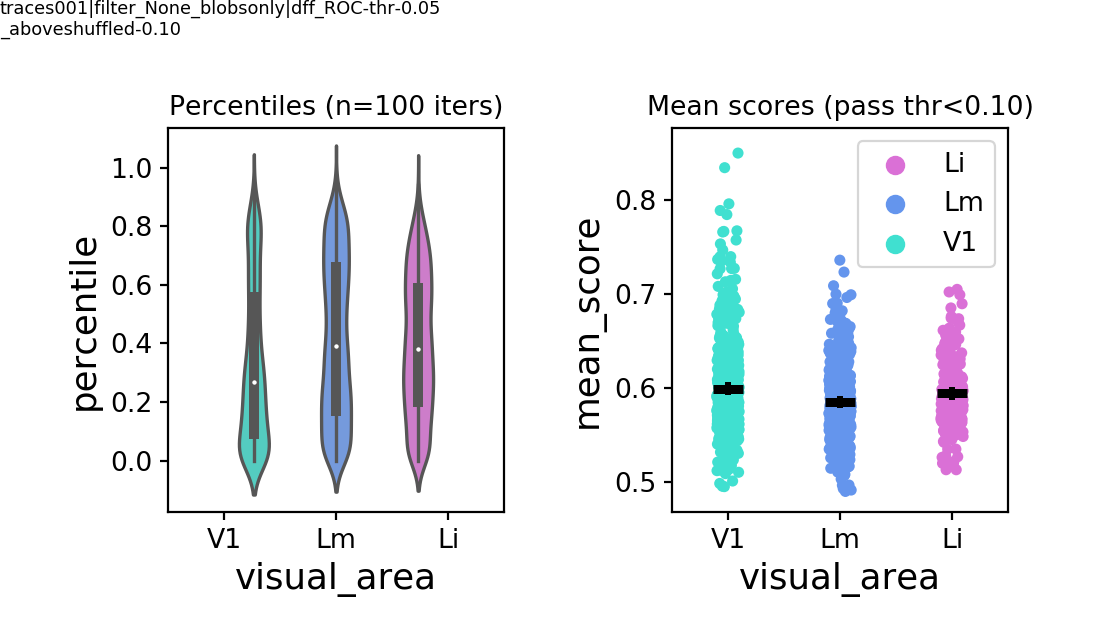

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'percentiles__ROC_aboveshuffled-0.10')


In [33]:

fig, axn = pl.subplots(1,2, figsize=(7, 4))
percentiles['percentile']= percentiles['percentile'].astype(float)

ax=axn[0]
ax.set_title('Percentiles (n=%i iters)' % n_iterations)
sns.violinplot(x='visual_area', y='percentile', data=percentiles, ax=ax,
              hue='visual_area', palette=area_colors, order=visual_areas)
ax.legend_.remove()

ax=axn[1]
ax.set_title('Mean scores (pass thr<%.2f)' % p_thr) # % n_iterations)
sns.stripplot(x='visual_area', y='mean_score', data=pass_perc, ax=ax,
              hue='visual_area', palette=area_colors, order=visual_areas, zorder=-1)
sns.pointplot(x='visual_area', y='mean_score', data=pass_perc, ax=ax,
              color='k', order=visual_areas, markers='_', scale=2, join=False, zorder=-1)
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1., 1), loc='left')

pl.subplots_adjust(wspace=0.5, left=0.15, bottom=0.2, right=0.9, top=0.8)
putils.label_figure(fig, '%s\n%s' % (data_id, pass_str))


figname = 'percentiles__%s%s' % ( responsive_test, pass_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

# Drop repeats

In [34]:
metric = 'heldout_test_score'
drop_repeats_by = 'most_cells' # 'min_missing'

# Drop repeat FOVs
pCELLS = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
           for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
            .groupby(['visual_area', 'datakey']).count().reset_index()
pCELLS = putils.split_datakey(pCELLS)

# if filter by fraction missing:
all_curr_dsets = pCELLS.copy()
curr_dsets = aggr.select_best_fovs(all_curr_dsets)

unique_dkeys = [(v, k) for (v, k), g in curr_dsets.groupby(['visual_area', 'datakey'])]

[V1] Animalid does not exist: JC078 


In [39]:
excl_dsets = [] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']

min_ncells=1

passdf_drop = pd.concat([g for (v, k), g in passdf.groupby(['visual_area', 'datakey']) \
                   if ((v, k) in unique_dkeys) & (len(g['cell'].unique())>=min_ncells) 
                      & (k not in excl_dsets)])
# passdf_drop = pd.concat([passdf[(passdf.visual_area==v) & (passdf.datakey==dk) & ~(passdf.datakey.isin(excl_dsets))] \
#                          for (v, dk), g in curr_dsets.groupby(['visual_area', 'datakey'])])
print("Drop repeats:")
print(passdf_drop[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


Drop repeats:
             datakey  cell
visual_area               
Li                70    70
Lm               153   153
V1               144   144


In [54]:
drop_repeats=True
dset_str = '_drop_repeats_by_%s' % drop_repeats_by if drop_repeats else "_all_datasets"

xdf = passdf_drop.copy() if drop_repeats else passdf.copy()


In [41]:
pass_str

'_aboveshuffled-0.10'

In [42]:
# min_ncells=5
# curr_dkeys = counts_by_fov[counts_by_fov['cell']>=min_ncells]['datakey'].unique()
# all_dkeys = counts_by_fov['datakey'].unique()
# print("%i of %i dkeys pass (min_ncells=%i)" % (len(curr_dkeys), len(all_dkeys), min_ncells))

In [43]:
# percentiles.groupby(['visual_area']).count().reset_index()[['visual_area', 'cell']]

In [44]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells'

In [45]:
itermean.head()

,visual_area,datakey,cell,condition,train_transform,test_transform,C,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,randi,iteration,n_cells,global_ix
0,Li,20190314_JC070_fov1,174,data,10_20_30_40,50,10.78246,0.003335,-0.007629,0.004811,0.531000,30.0,30.0,60.0,True,4786.03,2.0,1.0,0.0
1,Li,20190314_JC070_fov1,174,data,10_20_30_40,10_20_30_40,10.78246,0.012883,0.003059,0.018586,0.551042,120.0,120.0,240.0,False,4786.03,0.0,1.0,0.0
2,Li,20190314_JC070_fov1,174,data,10_20_30_50,40,11.58058,0.010057,0.002130,0.014509,0.555667,30.0,30.0,60.0,True,4521.56,5.0,1.0,0.0
3,Li,20190314_JC070_fov1,174,data,10_20_30_50,10_20_30_50,11.58058,0.011501,0.001001,0.016592,0.537708,120.0,120.0,240.0,False,4521.56,3.0,1.0,0.0
4,Li,20190314_JC070_fov1,174,data,10_20_40_50,30,1.86130,0.008339,-0.000337,0.012030,0.560333,30.0,30.0,60.0,True,4977.34,8.0,1.0,0.0


<IPython.core.display.Javascript object>


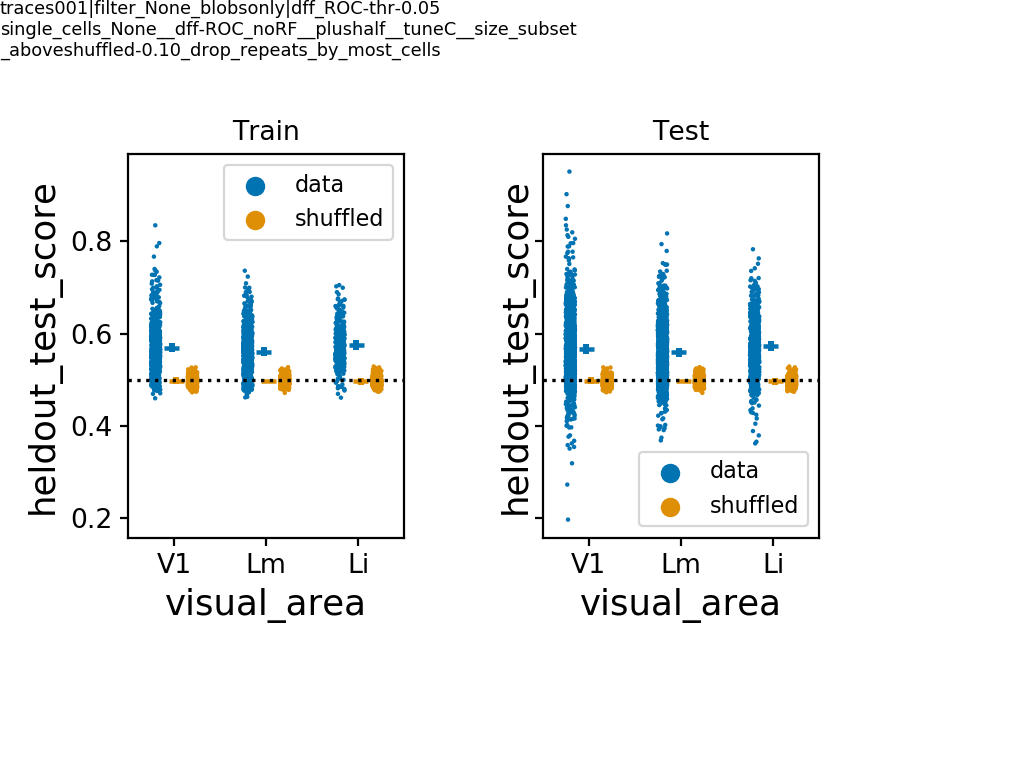

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_data-v-shuffled__aboveshuffled-0.10_drop_repeats_by_most_cells')


In [47]:
# xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]
#meandf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

fig, axn = pl.subplots(1, 2, sharey=True)
ax=axn[0]
metric='test_score' if test_type is None else 'heldout_test_score'
d_ = xdf.copy() if test_type is None else xdf[~xdf.novel]
ax.set_title('Train')
sns.stripplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


ax=axn[1]
metric='heldout_test_score'
d_ = xdf.copy() #if test_type is None else xdf[xdf.novel]
ax.set_title('Test')
sns.stripplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=2, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=d_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


putils.label_figure(fig, '%s\n%s\n%s%s' % (data_id, results_id, pass_str, dset_str))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)

figname = 'test_score__%s_data-v-shuffled_%s%s' % ( responsive_test, pass_str, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [59]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [48]:
xdf['visual_area'].unique()

array([u'Li', u'Lm', u'V1'], dtype=object)

In [49]:
area_colors

{'Li': 'orchid', 'Lm': 'cornflowerblue', 'V1': 'turquoise'}

In [50]:
passdf['visual_area'].unique()

array([u'Li', u'Lm', u'V1'], dtype=object)

In [55]:
if test_type is None:
    curr_metric = 'test_score'
    # xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(singledf['datakey'].isin(ign))]

    fig, axn = pl.subplots(1, 2, sharey=True, figsize=(7,4))
    ax=axn[0]
    metric='test_score' #curr_metric
    ax.set_title(metric)

    ax = stripplot_by_area(metric, xdf[xdf['condition']=='data'], ax=ax, visual_areas=visual_areas, 
                           area_colors=area_colors, 
                           size=2, bar=True, annotate=True, xytext=(0,50))
    ax = stripplot_by_area(metric, xdf[xdf['condition']=='shuffled'], ax=ax, visual_areas=visual_areas, 
                           area_colors=area_colors, 
                           size=2, bar=False, annotate=False)

    #### Label
    if 'test_score' in metric:
        #ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, color='k', ls=':')
    ax.legend_.remove()


    ax=axn[1]
    metric='heldout_%s' % curr_metric
    ax.set_title(metric)
    ax = stripplot_by_area(metric, xdf[xdf['condition']=='data'], ax=ax, visual_areas=visual_areas, 
                           area_colors=area_colors, size=2, bar=True, annotate=True, xytext=(0,50))

    #ax.legend(bbox_to_anchor=(1.2, 1))
    if 'test_score' in metric:
        #ax.set_ylim([0.4, 1])
        ax.axhline(y=0.5, color='k', ls=':')

    aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1.2, 1))

    putils.label_figure(fig, '%s | %s' % (data_id, results_id))
    pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
    pl.suptitle(pass_str)

    figname = 'test_score__%s_by_fov_%s' % (responsive_test, pass_str)
    #pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

    print(dst_dir, figname)

# Calculate mean performance for cell

In [56]:
meanscores_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

In [59]:
meanscores_by_cell[['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()

Lm    153
V1    144
Li     70
Name: visual_area, dtype: int64

Counts by area (n cells):
Lm    153
V1    144
Li     70
Name: visual_area, dtype: int64


<IPython.core.display.Javascript object>


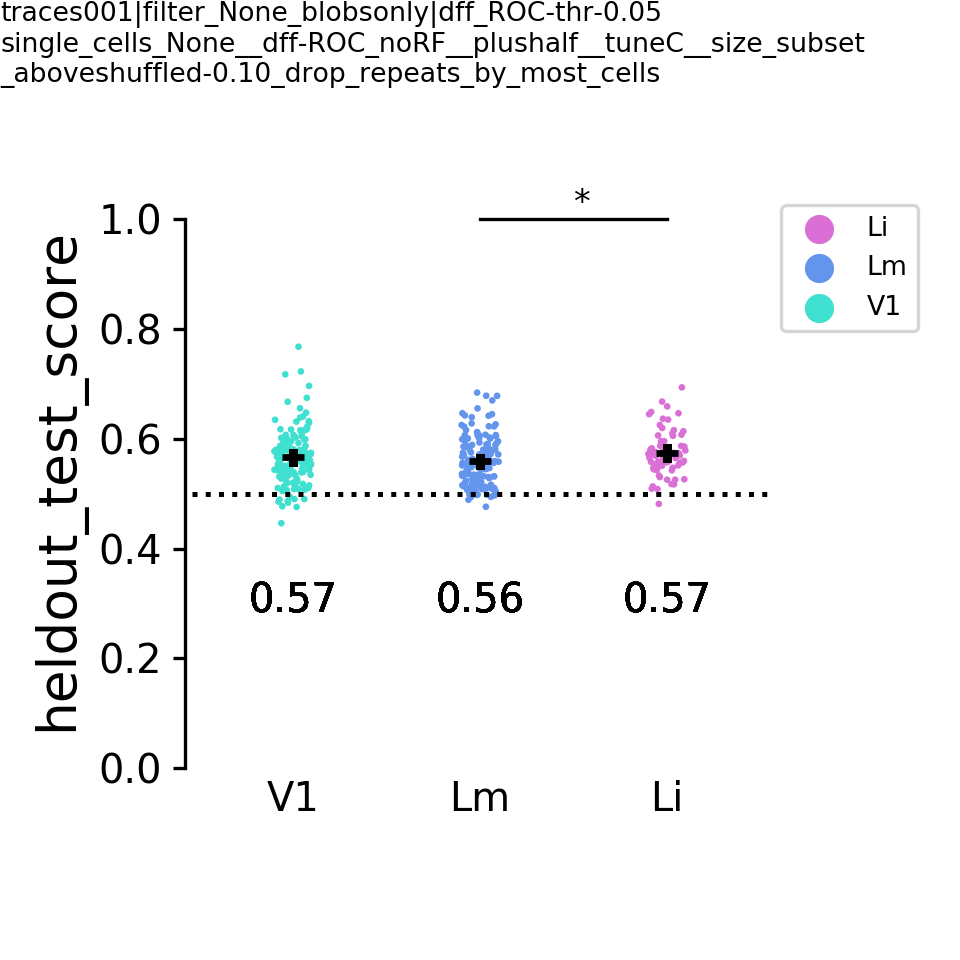

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
     U_val  d1  d2   n1   n2     p_val  reject
0  10008.0  V1  Lm  144  153  0.086587   False
1   4427.0  V1  Li  144   70  0.086587   False
2   4207.0  Lm  Li  153   70  0.015414    True
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_by_fov__aboveshuffled-0.10_drop_repeats_by_most_cells')


In [60]:
print("Counts by area (n cells):")
print(meanscores_by_cell[['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts())


fig, ax = pl.subplots( sharey=True, figsize=(4,4), dpi=dpi)

metric='heldout_test_score'
multi_comp_test='fdr_bh'
y_loc=0.8
offset=0.1

ax = stripplot_by_area(metric, meanscores_by_cell[meanscores_by_cell['condition']=='data'], 
                       ax=ax, visual_areas=visual_areas, 
                       area_colors=area_colors, size=2, bar=True, annotate=True, xytext=(0,50))
statresults, ax = aggr.plot_mannwhitney(meanscores_by_cell[meanscores_by_cell['condition']=='data'], 
                                    metric=metric, ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
if 'test_score' in metric:
    #ax.set_ylim([0.4, 1])
    ax.axhline(y=0.5, color='k', ls=':')
    
aggr.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1., 1), loc='upper left', fontsize=8)

sns.despine(offset=2, trim=True, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

putils.label_figure(fig, '%s\n%s\n%s%s' % (data_id, results_id, pass_str, dset_str))
pl.subplots_adjust(bottom=0.2, wspace=0.5, right=0.8, top=0.8, left=0.2)


figname = 'test_score__%s_by_fov_%s%s' % (responsive_test, pass_str, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [61]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells'

#### Compare scores by FOV

In [64]:
excl = ['20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190314_JC070_fov1',
        '20190327_JC073_fov1', '20191018_JC113_fov1', '20191111_JC120_fov1', '20190327_JC073_fov1']
excl=[]

for x in sorted(excl):
    print(x)

In [65]:
# excl=[]
counts_by_fov = xdf[xdf['condition']=='data'].groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
# min_ncells=10
# counts_by_fov[counts_by_fov['cell']<min_ncells]

In [72]:
means_by_fov = xdf.groupby(['visual_area', 'datakey', 'condition']).mean().reset_index()

N FOVs by area:
Li    10
Lm    10
V1     9
Name: visual_area, dtype: int64
Mean performance by area:
visual_area
Li    0.566225
Lm    0.548878
V1    0.562201
Name: heldout_test_score, dtype: float64


<IPython.core.display.Javascript object>


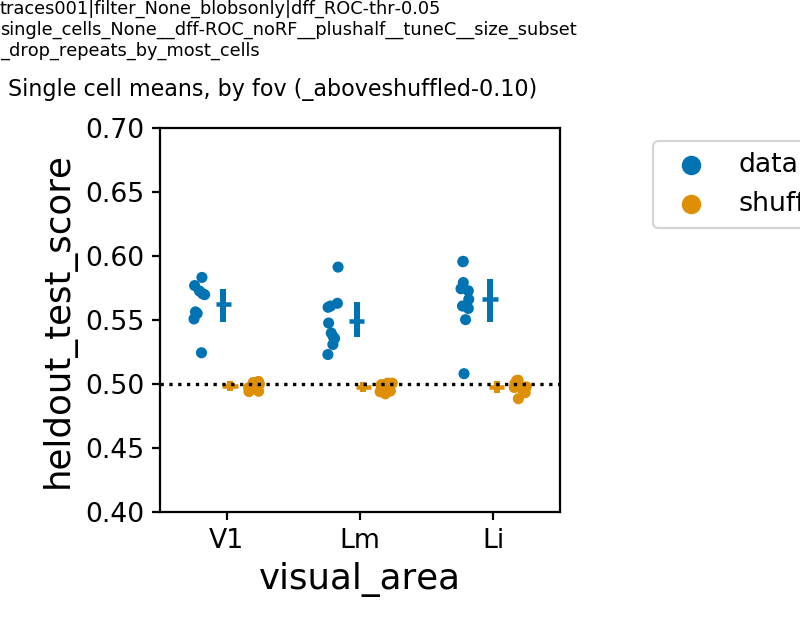

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
   U_val  d1  d2  n1  n2     p_val  reject
0   26.0  V1  Lm   9  10  0.098183   False
1   37.0  V1  Li   9  10  0.270146   False
2   25.0  Lm  Li  10  10  0.096033   False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'test_score__ROC_by_fov__aboveshuffled-0.10_drop_repeats_by_most_cells')


In [74]:
metric = 'heldout_test_score'
#metric = 'test_score'
multi_comp_test='fdr_bh'

df_ = means_by_fov[~means_by_fov['datakey'].isin(excl)]

print("N FOVs by area:")
print(df_[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts())
print("Mean performance by area:")
print(means_by_fov[means_by_fov.condition=='data'].groupby(['visual_area'])[metric].mean())


fig, ax = pl.subplots( sharey=True, figsize=(5,4))
sns.stripplot(x='visual_area',  y=metric, data=df_, ax=ax,
               hue='condition', dodge=True, palette='colorblind',
               order=visual_areas, size=5, zorder=0)
sns.pointplot(x='visual_area',  y=metric, data=df_, ax=ax,
               hue='condition', dodge=True, join=False,
               order=visual_areas, markers='_', palette='colorblind')
h, l = ax.get_legend_handles_labels()
ax.legend(h[0:2], l[0:2])
ax.axhline(y=0.5, color='k', ls=':')


#### Stats
statsresults, ax = aggr.plot_mannwhitney(df_[df_['condition']=='data'], 
                            metric=metric, multi_comp_test=multi_comp_test, 
                            ax=ax, y_loc=0.6, offset=0.01)
ax.set_ylim([0.4, 0.7])
aggr.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1.2, 1))


putils.label_figure(fig, '%s\n%s\n%s' % (data_id, results_id, dset_str))
pl.subplots_adjust(bottom=0.3, wspace=0.5, right=0.8, top=0.8)
fig.text(0.01, 0.85, 'Single cell means, by fov (%s)' % pass_str)
pl.subplots_adjust(left=0.2, top=0.8, bottom=0.2, right=0.7)


figname = 'test_score__%s_by_fov_%s%s' % (responsive_test, pass_str, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [45]:
# fig, ax = pl.subplots()
# sns.barplot(x='visual_area', y=metric, data=xdf, 
#            facecolor='w', edgecolor=('k', 'k', 'k'), order=visual_areas, ax=ax)
# sns.swarmplot(x='visual_area', y=metric, data=xdf, ax=ax,
#              palette=area_colors,  order=visual_areas,)

# xdf.apply(aggr.annotateBars, ax=ax, fontsize=12, fontcolor='k', xytext=(0, -40))


<IPython.core.display.Javascript object>


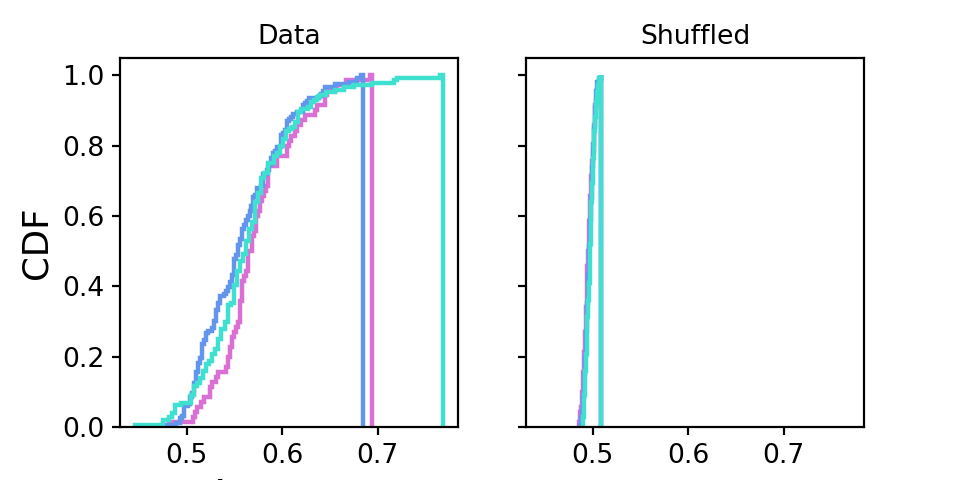

Text(0.5,1,u'Shuffled')

In [76]:
plot_means=True
metric='heldout_test_score'
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)

ax=axn[0]
# xdf = passdf[(passdf['datakey'].isin(curr_dkeys))]# & ~(df['datakey'].isin(ign))]

# xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
#xdf = passdf.copy() #[~(singledf['datakey'].isin(ign))].copy() 

means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()

if plot_means:
    plotd = means_by_cell.copy()
else:
    plotd = passdf[(passdf['datakey'].isin(curr_dkeys))].copy()
    

for visual_area, vdf in plotd[plotd['condition']=='data'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
ax.set_title('Data')
ax.set_ylabel('CDF')
ax.set_xlabel('Accuracy')

ax=axn[1]
for visual_area, vdf in plotd[plotd['condition']=='shuffled'].groupby(['visual_area']):
    n, bins, patches = ax.hist(vdf[metric].values, color=area_colors[visual_area],
                            density=True, histtype='step', cumulative=True, lw=2, bins=100)
ax.set_title('Shuffled')

In [77]:
aggr.do_mannwhitney(plotd[plotd['condition']=='data'], metric=metric, multi_comp_test='fdr_bh')


     U_val  d1  d2   n1   n2     p_val  reject
0  10008.0  V1  Lm  144  153  0.086587   False
1   4427.0  V1  Li  144   70  0.086587   False
2   4207.0  Lm  Li  153   70  0.015414    True


,U_val,d1,d2,n1,n2,p_val,reject
0,10008.0,V1,Lm,144,153,0.086587,False
1,4427.0,V1,Li,144,70,0.086587,False
2,4207.0,Lm,Li,153,70,0.015414,True


<IPython.core.display.Javascript object>


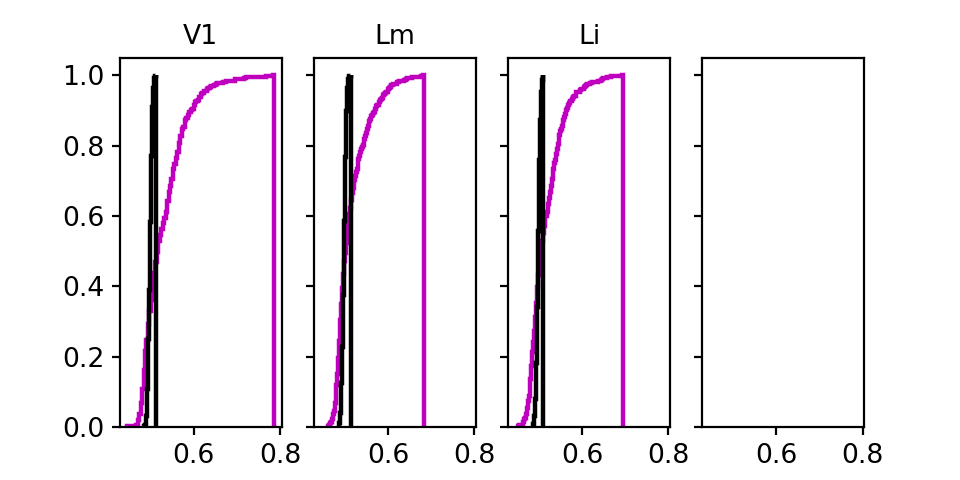

(u'Li', Ks_2sampResult(statistic=0.4935400516795866, pvalue=4.0310552410956074e-42))
(u'Lm', Ks_2sampResult(statistic=0.4358974358974359, pvalue=6.775849118380738e-56))
(u'V1', Ks_2sampResult(statistic=0.5904139433551198, pvalue=4.371157558637754e-71))


In [48]:
#xdf = singledf.copy() #[~(singledf['datakey'].isin(ign))].copy() 
means_by_cell = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition']).mean().reset_index()


fig, axn = pl.subplots(1,4, figsize=(6,3), sharex=True, sharey=True)
for ai, (visual_area, vdf) in enumerate(means_by_cell.groupby(['visual_area'])):
    ax=axn[2-ai]
    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    
    print("%s" % visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))
    
    n, bins, patches = ax.hist(d1[metric].values, color='m',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    n, bins, patches = ax.hist(d2[metric].values, color='k',
                            density=True, histtype='step', cumulative=True,lw=2, bins=100)
    
    ax.set_title(visual_area)
    

In [49]:
for visual_area in visual_areas:
    vdf = means_by_cell[means_by_cell['visual_area']==visual_area]

    d1 = vdf[vdf['condition']=='data'].copy()
    d2 = vdf[vdf['condition']=='shuffled'].copy()
    

    print(visual_area, spstats.ks_2samp(d1[metric].values, d2[metric].values))

('V1', Ks_2sampResult(statistic=0.5904139433551198, pvalue=4.371157558637754e-71))
('Lm', Ks_2sampResult(statistic=0.4358974358974359, pvalue=6.775849118380738e-56))
('Li', Ks_2sampResult(statistic=0.4935400516795866, pvalue=4.0310552410956074e-42))


# Tests

<IPython.core.display.Javascript object>


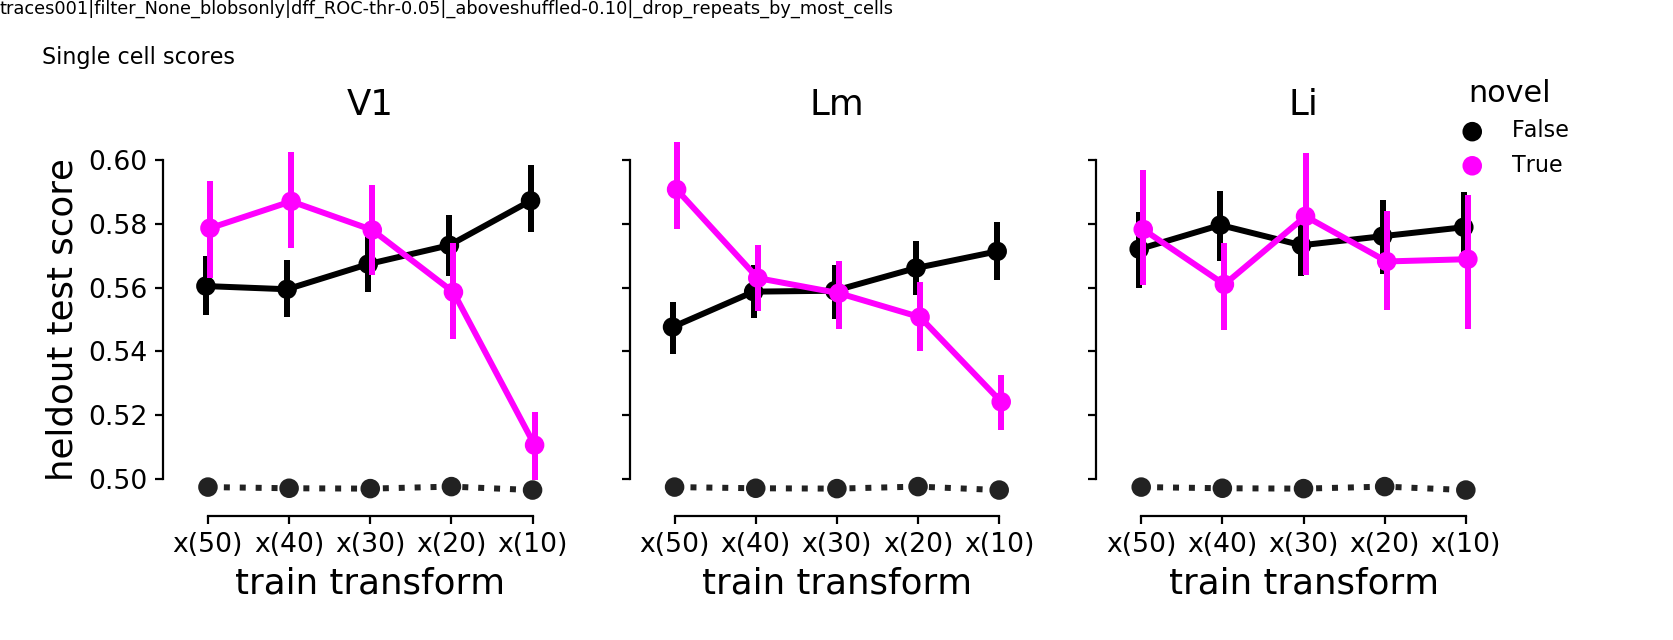

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/single_cells', 'generalization_novel-v-true_bycells__ROC_aboveshuffled-0.10_drop_repeats_by_most_cells')


In [79]:
plot_cells=True

gentest_colors = {True: 'magenta', False: 'k'}
gentest_styles = {True: '-', False: '-'}

metric_label='heldout test score'
mdf = xdf.groupby(['visual_area', 'datakey', 'cell', 'condition', 'train_transform', 'test_transform']).mean().reset_index()

mdf_by_fov = mdf.groupby(['condition', 'train_transform', 'test_transform','visual_area', 'datakey']).mean().reset_index()

plotd = mdf.copy() if plot_cells else mdf_by_fov.copy()
plot_str = 'bycells' if plot_cells else 'byfov'

g = sns.catplot(x='train_transform', y='heldout_test_score', data=plotd[plotd.condition=='data'], 
            hue='novel', palette=gentest_colors, dodge=True, kind='point', linestyles=gentest_styles,
            col='visual_area', col_order=visual_areas, height=4, aspect=0.8, legend_out=True)

g.map(sns.pointplot, x='train_transform', y='heldout_test_score', data=plotd[plotd.condition=='shuffled'],
      hue='novel', linestyles=':', legend_out=True)

(g.set_axis_labels("train transform", metric_label)\
     .set_titles("{col_name}")\
     .despine(offset=2)\
     .set_xticklabels(train_labels, fontsize=10))

#pl.ylim([0.49, 0.58])
pl.subplots_adjust(bottom=0.2, left=0.1, top=0.8, right=0.9, wspace=0.15)
g._legend.set(bbox_to_anchor=(0.95, 0.8))

putils.label_figure(g.fig, '%s|%s|%s' % (data_id, pass_str, dset_str))
g.fig.text(0.025, 0.9, 'Single cell scores')
sns.despine(trim=True, offset=2)

figname = 'generalization_novel-v-true_%s__%s%s%s' % ( plot_str, responsive_test, pass_str, dset_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

In [80]:
xdf.head()

,visual_area,datakey,cell,condition,train_transform,test_transform,C,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,randi,iteration,n_cells,global_ix
15,Li,20190315_JC070_fov1,113,data,10_20_30_40,50,0.81937,0.035767,0.039466,0.051601,0.617167,30.0,30.0,60.0,True,5180.38,2.0,1.0,7.0
16,Li,20190315_JC070_fov1,113,data,10_20_30_40,10_20_30_40,0.81937,0.014335,0.004996,0.020681,0.550208,120.0,120.0,240.0,False,5180.38,0.0,1.0,7.0
17,Li,20190315_JC070_fov1,113,data,10_20_30_50,40,23.06350,0.000800,-0.011357,0.001154,0.493500,30.0,30.0,60.0,True,5200.53,5.0,1.0,7.0
18,Li,20190315_JC070_fov1,113,data,10_20_30_50,10_20_30_50,23.06350,0.023395,0.018473,0.033752,0.586042,120.0,120.0,240.0,False,5200.53,3.0,1.0,7.0
19,Li,20190315_JC070_fov1,113,data,10_20_40_50,30,3.17224,0.005329,-0.004737,0.007689,0.547833,30.0,30.0,60.0,True,4833.05,8.0,1.0,7.0


In [81]:
xdf.sample(n=2, )

,visual_area,datakey,cell,condition,train_transform,test_transform,C,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,n_samples_0,n_samples_106,n_trials,novel,randi,iteration,n_cells,global_ix
7399,V1,20190617_JC097_fov1,40,data,10_20_40_50,30,4.62430,0.070392,0.090325,0.101554,0.682833,30.0,30.0,60.0,True,5367.34,8.0,1.0,814.0
1934,Lm,20190430_JC078_fov1,8,shuffled,20_30_40_50,20_30_40_50,1.11358,0.007256,0.001234,0.010469,0.500851,116.0,116.0,232.0,False,4937.72,13.0,1.0,91.0
